# Objective

# Potentential improvements

- Use unbalanced dataset vs artificially balanced
- Use a different method of feature selection (*e.g. correlation, Recursive feature selection*) 
- Include more or different algorithms
- Include more parameters as part of the Hyper Parameter Tuning process

# Preparation

## Load libraries

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn import preprocessing
from sklearn import metrics as met
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import RadiusNeighborsClassifier, KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.utils import resample
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import randint
import os
import errno

In [2]:
%load_ext pycodestyle_magic
%flake8_on
%matplotlib inline

### Create folder structure

In [3]:
os.chdir('..')
output_folder = './reports/figures/'
cleaned_folder = './data/processed/'
external_data = './data/external/'

# Import data

In [4]:
x_train = pd.read_csv(cleaned_folder+'x_train.csv')
x_test = pd.read_csv(cleaned_folder+'x_test.csv')
y_train = pd.read_csv(cleaned_folder+'y_train.csv', dtype='int64')
y_test = pd.read_csv(cleaned_folder+'y_test.csv', dtype='int64')
test_df = pd.read_csv(cleaned_folder+'test_df.csv')
test_ids_df = pd.read_csv(cleaned_folder+'test_ids_df.csv')

In [5]:
y_test = y_test['TARGET']
y_train = y_train['TARGET']

# Balance dataset

In [6]:
# Verify that the dataset is balanced
y_train.value_counts(normalize=False)

0    168267
1     15238
Name: TARGET, dtype: int64

**Result**: dataset unbalanced with only 9% customers with payment difficulties, which can be expected.

*While some algorithms can work with unbalanced datasets, we will be balancing the dataset to allow for algorithms that require a balanced sample.*

In [7]:
# Merge outcome variable & features
train_df = pd.concat([x_train, y_train], axis=1)

In [8]:
# Separate dataset based on outcome variable
no_pay_prob = train_df[train_df['TARGET'] == 0]
pay_prob = train_df[train_df['TARGET'] == 1]

In [9]:
# upsample - artificially add customers with payment difficulties
# Reason for upsampling is that our dataset is relatively small
pay_prob2 = resample(pay_prob,
                     replace=True,  # sample with replacement
                     n_samples=len(no_pay_prob),  # dataset to match customers without payment problems
                     random_state=18)

5:80: E501 line too long (103 > 79 characters)


In [10]:
# Count of customers with payment difficulties
pay_prob.shape

(15238, 27)

In [11]:
# New count of customers without payment difficulties
pay_prob2.shape

(168267, 27)

In [12]:
# Combine dataset with added cases
train_df = pd.concat([pay_prob2, no_pay_prob])

In [13]:
# Separate dataset in preparation of modelling
y_train = train_df['TARGET']
x_train = train_df.drop('TARGET', axis=1)

# Feature selection

In [14]:
rf_feature_select = SelectFromModel(RandomForestClassifier(n_estimators=100))
rf_feature_select.fit(x_train, y_train)

rf_sel_feature_count = rf_feature_select.get_support()
rf_selected_features = x_train.loc[:, rf_sel_feature_count].columns.tolist()
print(str(len(rf_selected_features)), 'selected features')

16 selected features


In [15]:
print('Selected features:', rf_selected_features)

Selected features: ['REGION_POPULATION_RELATIVE_DAYS_REGISTRATION', 'DAYS_REGISTRATION_DAYS_LAST_PHONE_CHANGE', 'DAYS_LAST_PHONE_CHANGE_AMT_ANNUITY', 'REGION_POPULATION_RELATIVE_DAYS_EMPLOYED', 'DAYS_EMPLOYED_AMT_INCOME_TOTAL', 'DAYS_BIRTH_AMT_INCOME_TOTAL', 'DAYS_REGISTRATION_AMT_GOODS_PRICE', 'DAYS_EMPLOYED_CNT_FAM_MEMBERS', 'DAYS_ID_PUBLISH_DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH_AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS_DAYS_LAST_PHONE_CHANGE', 'REGION_POPULATION_RELATIVE_DAYS_ID_PUBLISH', 'DAYS_EMPLOYED_AMT_ANNUITY', 'DAYS_EMPLOYED_DAYS_LAST_PHONE_CHANGE', 'DAYS_EMPLOYED_DAYS_REGISTRATION', 'REGION_POPULATION_RELATIVE_DAYS_LAST_PHONE_CHANGE']


In [16]:
# Select strongest features
x_train = x_train[rf_selected_features]
x_test = x_test[rf_selected_features]
test_df = test_df[rf_selected_features]

# Algorithm selection

We will be using 'recall' as an evaluation metric for algorithm performance, because:
- The original dataset is unbalanced; most people don't have payment difficulties
- The objective of this analysis is to correctly identify customers with payment difficulties

Recall = the number of correctly classified customers with payment difficulties = True Positives / (True Positives + False Negatives)

In [17]:
classifiers = {'Gradient Boosting Classifier': GradientBoostingClassifier(),
               'Ada Boost Classifier': AdaBoostClassifier(),
               'Linear Discriminant Analyis': LinearDiscriminantAnalysis(),
               'GaussianNB': GaussianNB(),
               'BernoulliNB': BernoulliNB(),
               'KNN': KNeighborsClassifier(),
               'Random Forest Classifier': RandomForestClassifier(),
               'Decision Tree Classifier': DecisionTreeClassifier(),
               'Logistic Regression': LogisticRegression()}

In [18]:
# Evaluate strongest predicting algorithm in default setting
base_score = 0
model_outcomes = []
for Name, classify in classifiers.items():
    classify.fit(x_train, y_train)
    predicting_y = classify.predict(x_test)
    model_outcomes.append({
    'Algorithm': str(Name),
    'Recall_score': str(met.recall_score(y_test, predicting_y))
    })

    if met.recall_score(y_test, predicting_y) > base_score:
        # prediction = classify.predict(test_df)
        base_score = met.recall_score(y_test, predicting_y)

    else:
        continue

8:5: E122 continuation line missing indentation or outdented
9:5: E122 continuation line missing indentation or outdented


In [19]:
model_scores = pd.DataFrame(model_outcomes, columns=['Algorithm', 'Recall_score'])
model_scores.sort_values(by=['Recall_score'], ascending=False)

,Algorithm,Recall_score
3,GaussianNB,0.7691829760795278
4,BernoulliNB,0.666511338925132
2,Linear Discriminant Analyis,0.6439888164026095
8,Logistic Regression,0.6425908667287977
1,Ada Boost Classifier,0.6298539919229574
0,Gradient Boosting Classifier,0.5984777881329606
5,KNN,0.2775706741223983
7,Decision Tree Classifier,0.09676918297607953
6,Random Forest Classifier,0.0


1:80: E501 line too long (82 > 79 characters)


Best algorithms according to model evaluation:
<ol>
<li> GaussianNB </li>
<li> BernoulliNB </li>
<li> Linear Discriminant Analyis </li>
<li> Logistic regression </li>

# Hyper parameter tuning
Optimise the top performing algorithms to create the best possible prediction

In [20]:
classifiers = {'Random_forest': {'model': RandomForestClassifier(),
                                 'params': {'n_estimators': [31, 35, 37]}},
               'Logistic_regression': {'model': LogisticRegression(solver='liblinear', multi_class='auto'),
                                       'params': {'C': [1, 10, 100, 1000],
                                                  'penalty': ['l1', 'l2'], }},
               'AdaBoostClassifier': {'model': AdaBoostClassifier(DecisionTreeClassifier(), random_state=7),
                                      'params': {'base_estimator__criterion': ["gini", "entropy"],
                                                 'base_estimator__splitter':   ["best", "random"],
                                                 'learning_rate':  [0.1, 0.3, 1.5]}},
               'GradientBoostingClassifier': {'model': GradientBoostingClassifier(),
                                              'params': {'loss': ["deviance"],
                                                         'n_estimators': [360, 380, 400],
                                                         'learning_rate': [0.015, 0.02, 0.03],
                                                         'max_depth': [2, 3, 4],
                                                         'min_samples_leaf': [60, 70, 80]}},
               'KNearestNeighbors': {'model': KNeighborsClassifier(),
                                     'params': {'n_neighbors': [2, 5, 7],
                                                'metric': ['euclidean', 'minkowski']}},
               'DecisionTreeClassifier': {'model': DecisionTreeClassifier(),
                                          'params': {'criterion': ["gini", "entropy"],
                                                     'splitter': ['best', 'random'],
                                                     'max_depth': [3, None],
                                                     'max_features': [1, 5, 9],
                                                     'min_samples_leaf': [1, 5, 9]}}}

3:80: E501 line too long (107 > 79 characters)
6:80: E501 line too long (108 > 79 characters)
7:80: E501 line too long (98 > 79 characters)
8:80: E501 line too long (98 > 79 characters)
9:80: E501 line too long (85 > 79 characters)
10:80: E501 line too long (84 > 79 characters)
12:80: E501 line too long (89 > 79 characters)
13:80: E501 line too long (94 > 79 characters)
14:80: E501 line too long (80 > 79 characters)
15:80: E501 line too long (92 > 79 characters)
18:80: E501 line too long (87 > 79 characters)
20:80: E501 line too long (86 > 79 characters)
21:80: E501 line too long (84 > 79 characters)


In [21]:
# Selected classifiers based on model performance

In [22]:
# Select classifier algorithms to optimise
# NB: GaussianNB doesn't have any parameters to optimise
classifiers = {'Logistic_regression': {'model': LogisticRegression(solver='liblinear', multi_class='auto'),
                                       'params': {'C': [1, 10, 100, 1000],
                                                  'penalty': ['l1', 'l2'], }},
               'LinearDiscriminant': {'model': LinearDiscriminantAnalysis(solver='svd'),
                                      'params': {'tol': [0.0001, 0.0002, 0.0003]}},
               'BernoulliNB': {'model': BernoulliNB(),
                               'params': {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}}}

scores = []
for model_name, mp in classifiers.items():
    grid = GridSearchCV(mp['model'],
                        mp['params'],
                        cv=10,
                        scoring='recall',
                        return_train_score=False,
                        n_jobs=-1)
    grid.fit(x_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': grid.best_score_,
        'best_params': grid.best_params_
    })

3:80: E501 line too long (107 > 79 characters)
6:80: E501 line too long (88 > 79 characters)
7:80: E501 line too long (83 > 79 characters)
9:80: E501 line too long (81 > 79 characters)


model_scores = pd.DataFrame(model_outcomes, columns=['Algorithm', 'Recall_score'])
model_scores.sort_values(by=['Recall_score'], ascending=False)

In [23]:
# Create table with best parameters per algorithm
model_parameters = pd.DataFrame(scores, columns=['model',
                                                 'best_score',
                                                 'best_params'])
model_parameters.sort_values(by=['best_score'], ascending=False)

,model,best_score,best_params
2,BernoulliNB,0.663963,{'alpha': 0.01}
1,LinearDiscriminant,0.641385,{'tol': 0.0001}
0,Logistic_regression,0.639793,"{'C': 1, 'penalty': 'l1'}"


**Result:** models perform slightly better than before parameter optimisation

# Modelling

Use the earlier identified top 3 algorithms with best performing parameters

In [24]:
model1 = GaussianNB()
model1.fit(x_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [25]:
model2 = BernoulliNB(alpha=0.01)
model2.fit(x_train, y_train)

BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=True)

In [26]:
model3 = LinearDiscriminantAnalysis(tol=0.0001)
model3.fit(x_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [27]:
model4 = LogisticRegression(solver='liblinear',
                            multi_class='auto',
                            C=1,
                            penalty='l1')
model4.fit(x_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

# Model evaluation

In [28]:
# Create predictions from the training data on the test data
y_pred_mod_1 = model1.predict(x_test)
y_pred_mod_2 = model2.predict(x_test)
y_pred_mod_3 = model3.predict(x_test)
y_pred_mod_4 = model4.predict(x_test)

In [29]:
# Evaluate model based on training data
pred_prob_1 = model1.predict_proba(x_test)
pred_prob_2 = model2.predict_proba(x_test)
pred_prob_3 = model3.predict_proba(x_test)
pred_prob_4 = model4.predict_proba(x_test)

In [30]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob_1[:, 1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob_2[:, 1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob_3[:, 1], pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(y_test, pred_prob_4[:, 1], pos_label=1)

In [31]:
# Create benchmark predictions based on random chance for ROC comparison
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [32]:
# Calculate auc scores
auc_score1 = roc_auc_score(y_test, pred_prob_1[:, 1])
auc_score2 = roc_auc_score(y_test, pred_prob_2[:, 1])
auc_score3 = roc_auc_score(y_test, pred_prob_3[:, 1])
auc_score4 = roc_auc_score(y_test, pred_prob_4[:, 1])

print('Model1 AUC:', auc_score1, 'Model2 AUC:', auc_score2, 'Model3 AUC:', auc_score3, 'Model4 AUC:', auc_score4)

Model1 AUC: 0.6029413262282557 Model2 AUC: 0.595283888202523 Model3 AUC: 0.6014868423074142 Model4 AUC: 0.6015862381225755


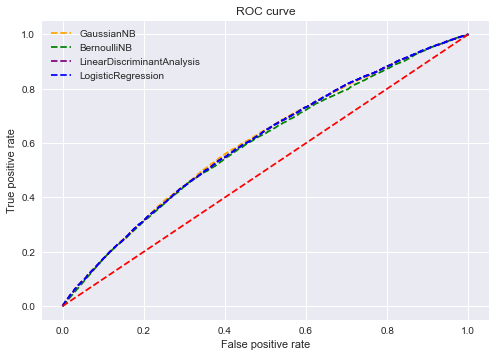

8:80: E501 line too long (88 > 79 characters)


In [33]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--', color='orange', label='GaussianNB')
plt.plot(fpr2, tpr2, linestyle='--', color='green', label='BernoulliNB')
plt.plot(fpr3, tpr3, linestyle='--', color='purple', label='LinearDiscriminantAnalysis')
plt.plot(fpr4, tpr4, linestyle='--', color='blue', label='LogisticRegression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='red')
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.legend(loc='best')
plt.savefig(cleaned_folder+'ROC_graph', dpi=300)
plt.show()

Based on the above graph, the Gaussia Naive Bayes is the best at predicting customers with payment difficulties, but only slightly better than the other models.

In [34]:
# Create confusion matrix
print("Confusion matrix model 1")
y_actual = pd.Series(y_test, name='Actual')
y_predicted = pd.Series(y_pred_mod_1, name='Predicted')
pd.crosstab(y_actual, y_predicted)

Confusion matrix model 1


Predicted,0,1
Actual,,
0,25664,46543
1,1486,4952


In [35]:
print(classification_report(y_predicted, y_actual))

              precision    recall  f1-score   support

           0       0.36      0.95      0.52     27150
           1       0.77      0.10      0.17     51495

    accuracy                           0.39     78645
   macro avg       0.56      0.52      0.34     78645
weighted avg       0.63      0.39      0.29     78645



In [36]:
# Create confusion matrix
print("Confusion matrix model 2")
y_actual = pd.Series(y_test, name='Actual')
y_predicted = pd.Series(y_pred_mod_2, name='Predicted')
pd.crosstab(y_actual, y_predicted)

Confusion matrix model 2


Predicted,0,1
Actual,,
0,33506,38701
1,2147,4291


In [37]:
print(classification_report(y_predicted, y_actual))

              precision    recall  f1-score   support

           0       0.46      0.94      0.62     35653
           1       0.67      0.10      0.17     42992

    accuracy                           0.48     78645
   macro avg       0.57      0.52      0.40     78645
weighted avg       0.57      0.48      0.38     78645



In [38]:
# Create confusion matrix
print("Confusion matrix model 3")
y_actual = pd.Series(y_test, name='Actual')
y_predicted = pd.Series(y_pred_mod_3, name='Predicted')
pd.crosstab(y_actual, y_predicted)

Confusion matrix model 3


Predicted,0,1
Actual,,
0,36278,35929
1,2292,4146


In [39]:
print(classification_report(y_predicted, y_actual))

              precision    recall  f1-score   support

           0       0.50      0.94      0.65     38570
           1       0.64      0.10      0.18     40075

    accuracy                           0.51     78645
   macro avg       0.57      0.52      0.42     78645
weighted avg       0.57      0.51      0.41     78645



In [40]:
# Create confusion matrix
print("Confusion matrix model 4")
y_actual = pd.Series(y_test, name='Actual')
y_predicted = pd.Series(y_pred_mod_4, name='Predicted')
pd.crosstab(y_actual, y_predicted)

Confusion matrix model 4


Predicted,0,1
Actual,,
0,36436,35771
1,2301,4137


In [41]:
print(classification_report(y_predicted, y_actual))

              precision    recall  f1-score   support

           0       0.50      0.94      0.66     38737
           1       0.64      0.10      0.18     39908

    accuracy                           0.52     78645
   macro avg       0.57      0.52      0.42     78645
weighted avg       0.57      0.52      0.41     78645



# Create final model

In [42]:
# Combine train and test datasets
x_df = pd.concat([x_train, x_test])
y_df = pd.concat([y_train, y_test])

In [43]:
x_df.shape

(415179, 16)

In [44]:
y_df.shape

(415179,)

In [45]:
final_model = GaussianNB()
final_model.fit(x_df, y_df)

GaussianNB(priors=None, var_smoothing=1e-09)

# Submission

In [46]:
# Create predictions based on generated model
prediction = final_model.predict(test_df)

In [47]:
# Generate Submission File
SK_ID_CURR = list(test_ids_df['SK_ID_CURR'])
predicted_test_values = pd.DataFrame({'SK_ID_CURR': SK_ID_CURR, 'TARGET': prediction})
predicted_test_values.to_csv(external_data + 'Submission_file.csv', index=False)

3:80: E501 line too long (86 > 79 characters)


In [48]:
prediction.shape

(40788,)